# Encoder Decoder

## Set up

In [6]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [7]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [8]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20

loaded numpy bitmaps, 8 classes
[144722, 194843, 120527, 121661, 142167, 134680, 143570, 156883]


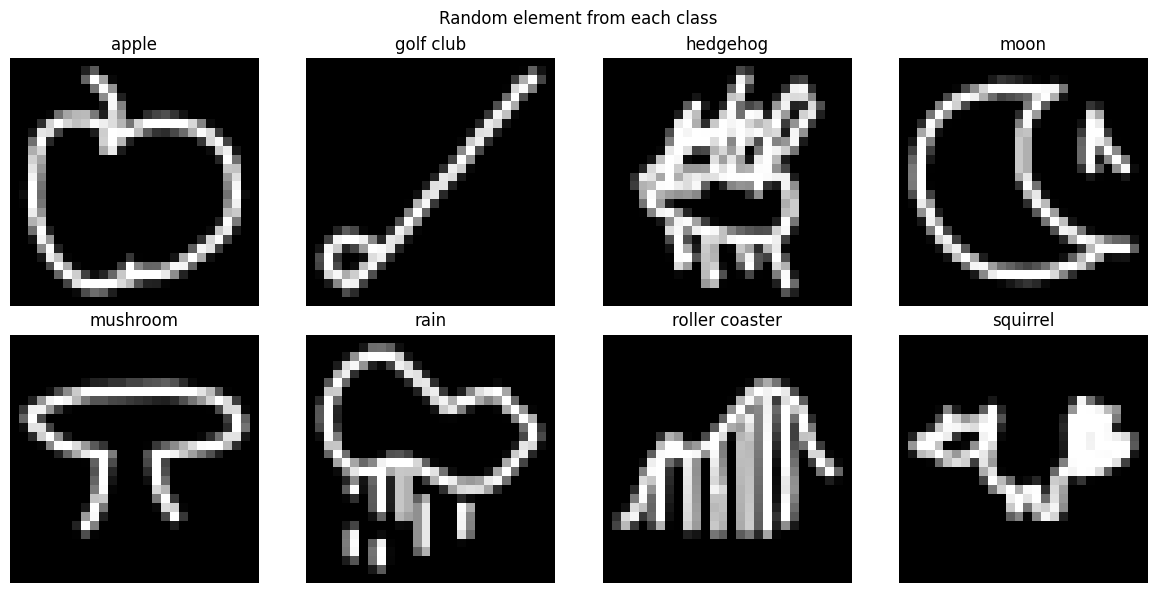

In [9]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

classes_sizes = []

for i in range(nb_classes):
    classes_sizes.append(len(data[i]))

images = []
labels = []

# Reshape and parse data to image and labels
for i in range(nb_classes):
    for j in range(classes_sizes[i]):
        images.append(data[i][j].reshape(HEIGHT, WIDTH))
        labels.append(classes[i])

print(classes_sizes)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
# Show image for each class
for i in range(nb_classes):
    # Sum of previous classes_size
    start_index = sum(classes_sizes[:i])
    end_index = start_index + classes_sizes[i]

    # Random element from each class
    random_index = random.randint(start_index, end_index)

    axes[i // num_cols, i % num_cols].imshow(images[random_index], cmap='gray')
    axes[i // num_cols, i % num_cols].set_title(labels[random_index])
    axes[i // num_cols, i % num_cols].axis('off')
    

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

In [10]:
# Show len of train and test data
print(f'Train data: {len(images)}')
print(f'Test data: {len(labels)}')

Train data: 1159053
Test data: 1159053


In [11]:
class Autoencoder(nn.Module):
    def __init__(self, layer_sizes=[WIDTH * HEIGHT, 128, 64, 32]):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Add encoder layers
        for i in range(len(layer_sizes) - 1):
            self.encoder.add_module(f"encoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.encoder.add_module(f"encoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        # Add decoder layers
        for i in range(len(layer_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1:
                self.decoder.add_module(f"decoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))
                self.encoder.add_module(f"encoder_batchnorm_{i}", nn.BatchNorm1d(layer_sizes[i+1]))

        self.decoder.add_module("decoder_sigmoid", nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

    def print_model(self):
        print(self.encoder)
        print(self.decoder)

## Try with simple model

In [12]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 3]
autoencoder_model = Autoencoder(architecture_1).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [13]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=261, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=261, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.003831417624521


In [14]:
# Too much images, take sub part (10000)
sub_dataset_size = 4000

# print percentage used
print(f'Percentage of data used: {sub_dataset_size / len(images) * 100}%')

# Suffle data and split images and labels into train and test sets
shuffler = np.random.permutation(len(images))
print(shuffler)
split_percentage = 0.8

train_images = []
train_labels = []

test_images = []
test_labels = []

for i in range(sub_dataset_size):
    if i < sub_dataset_size * split_percentage:
        train_images.append(images[shuffler[i]])
        train_labels.append(labels[shuffler[i]])
    else:
        test_images.append(images[shuffler[i]])
        test_labels.append(labels[shuffler[i]])


# Normalize data and convert to PyTorch tensors
train_normalized_images = np.array(train_images).astype(np.float32) / 255.0
train_torch_images = torch.from_numpy(train_normalized_images).to(device)

test_normalized_images = np.array(test_images).astype(np.float32) / 255.0
test_torch_images = torch.from_numpy(test_normalized_images).to(device)

print(train_labels[:20])
 

Percentage of data used: 0.3451093263207118%
[472982 896517 335867 ... 412117  78273 824553]
['moon', 'roller coaster', 'golf club', 'apple', 'mushroom', 'rain', 'roller coaster', 'apple', 'roller coaster', 'rain', 'rain', 'rain', 'squirrel', 'hedgehog', 'roller coaster', 'roller coaster', 'squirrel', 'apple', 'mushroom', 'roller coaster']


In [15]:
def train_autoencoder(autoencoder_model, train_set, test_set, criterion, optimizer, num_epochs, batch_size):
    train_psnr_values = []
    train_ssim_values = []

    test_psnr_values = []
    test_ssim_values = []

    train_loss_values = []
    test_loss_values = []

    for epoch in range(num_epochs):
        # Train by batch of images
        for i in range(0, len(train_set), batch_size):
            train_batch = train_set[i:i+batch_size]

            train_torch_images = torch.from_numpy(train_batch).to(device)
            
            # Forward pass
            encoded, decoded = autoencoder_model(train_batch.view(-1, WIDTH * HEIGHT))
            loss = criterion(decoded, train_batch.view(-1, WIDTH * HEIGHT))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Train loss, test loss
        train_loss_values.append(loss.item())
        test_loss_values.append(
            criterion(autoencoder_model(test_set.view(-1, WIDTH * HEIGHT))[1], test_set.view(-1, WIDTH * HEIGHT)).item())

        # Calculate PSNR and SSIM for train and test sets
        train_psnr = 0
        train_ssim = 0
        test_psnr = 0
        test_ssim = 0

        for image in train_set:
            encoded, decoded = autoencoder_model(image.view(-1, WIDTH * HEIGHT))
            decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

            image_matrix = image.cpu().detach().numpy()
            decoded_matrix = decoded.cpu().detach().numpy()[0]

            train_psnr += psnr(image_matrix, decoded_matrix)
            train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        for image in test_set:
            encoded, decoded = autoencoder_model(image.view(-1, WIDTH * HEIGHT))
            decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

            image_matrix = image.cpu().detach().numpy()
            decoded_matrix = decoded.cpu().detach().numpy()[0]

            test_psnr += psnr(image_matrix, decoded_matrix)
            test_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        train_psnr /= len(train_set)
        train_ssim /= len(train_set)
        test_psnr /= len(test_set)
        test_ssim /= len(test_set)

        train_psnr_values.append(train_psnr)
        train_ssim_values.append(train_ssim)
        test_psnr_values.append(test_psnr)
        test_ssim_values.append(test_ssim)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_values[-1]:.4f}, Test Loss {test_loss_values[-1]:.4f}, ', end = "")
        print(f'Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}')

    return train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values

In [16]:
# Call the function
num_epochs = 50
batch_size = 16
train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autoencoder_model, train_torch_images, test_torch_images, criterion, optimizer, num_epochs, batch_size)
    

Epoch [1/50], Loss: 0.0603, Test Loss 0.0583, Train PSNR: 12.7987, Train SSIM: 0.3349, Test PSNR: 12.6353, Test SSIM: 0.3250
Epoch [2/50], Loss: 0.0377, Test Loss 0.0395, Train PSNR: 14.7535, Train SSIM: 0.4980, Test PSNR: 14.4015, Test SSIM: 0.4797
Epoch [3/50], Loss: 0.0264, Test Loss 0.0286, Train PSNR: 16.3612, Train SSIM: 0.5902, Test PSNR: 15.8259, Test SSIM: 0.5695
Epoch [4/50], Loss: 0.0198, Test Loss 0.0216, Train PSNR: 17.7708, Train SSIM: 0.6508, Test PSNR: 17.0739, Test SSIM: 0.6308
Epoch [5/50], Loss: 0.0156, Test Loss 0.0173, Train PSNR: 18.9200, Train SSIM: 0.6923, Test PSNR: 18.0841, Test SSIM: 0.6739
Epoch [6/50], Loss: 0.0130, Test Loss 0.0145, Train PSNR: 19.8832, Train SSIM: 0.7236, Test PSNR: 18.9051, Test SSIM: 0.7064
Epoch [7/50], Loss: 0.0111, Test Loss 0.0126, Train PSNR: 20.6900, Train SSIM: 0.7476, Test PSNR: 19.5724, Test SSIM: 0.7313
Epoch [8/50], Loss: 0.0097, Test Loss 0.0112, Train PSNR: 21.3930, Train SSIM: 0.7676, Test PSNR: 20.1362, Test SSIM: 0.7519


In [17]:
# Define a function to plot Train and Test Loss, PSNR and SSIM values
def plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].plot(train_loss_values, label='Train Loss')
    axes[0].plot(test_loss_values, label='Test Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(train_psnr_values, label='Train PSNR')
    axes[1].plot(test_psnr_values, label='Test PSNR')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('PSNR')
    axes[1].legend()

    axes[2].plot(train_ssim_values, label='Train SSIM')
    axes[2].plot(test_ssim_values, label='Test SSIM')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('SSIM')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


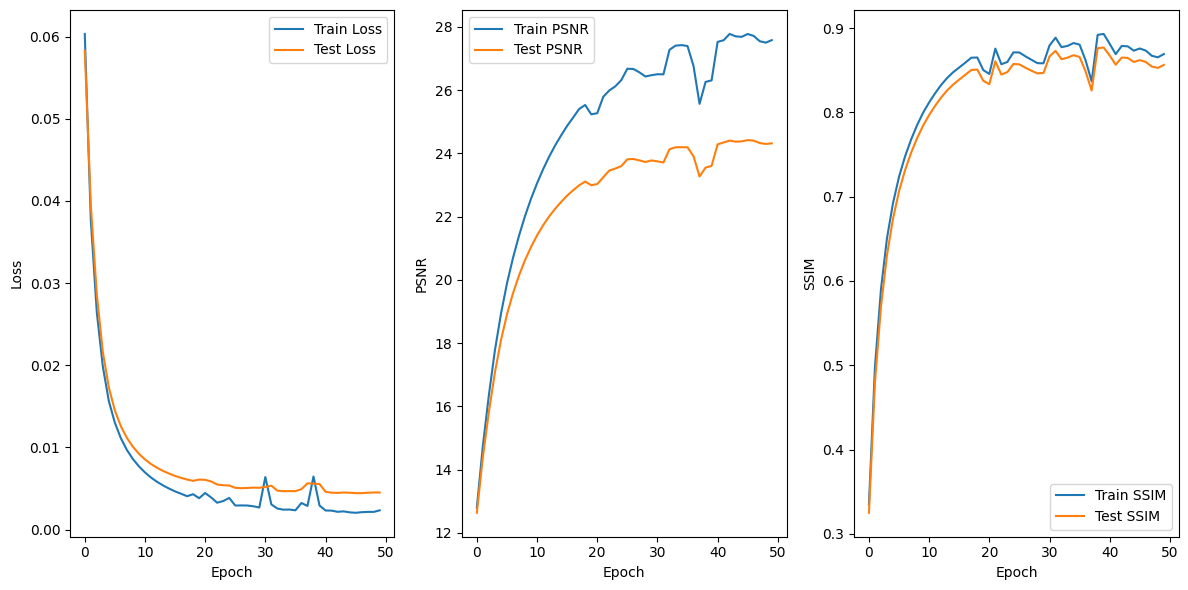

In [18]:
# Call the function
plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

In [19]:
# Define a function to show original and reconstructed images
def show_images(train_images, train_labels, autoencoder_model):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

    for i in range(num_cols // 2):
        # Train images
        index = random.randint(0, len(train_images))

        axes[0, i].imshow(train_images[index], cmap='gray')
        axes[0, i].set_title(f"Train original {train_labels[index]}")
        axes[0, i].axis('off')

        # Reconstructed images
        encoded, decoded = autoencoder_model(train_torch_images[index].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Train reconstructed {train_labels[index]}")
        axes[1, i].axis('off')
    
    for i in range(num_cols // 2, num_cols):
        # Test images
        index = random.randint(0, len(test_images))

        axes[0, i].imshow(test_images[index], cmap='gray')
        axes[0, i].set_title(f"Test original, {test_labels[index]}")
        axes[0, i].axis('off')

        # Reconstructed images
        encoded, decoded = autoencoder_model(test_torch_images[index].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(f"Test reconstructed {test_labels[index]}")
        axes[1, i].axis('off')


    plt.show()

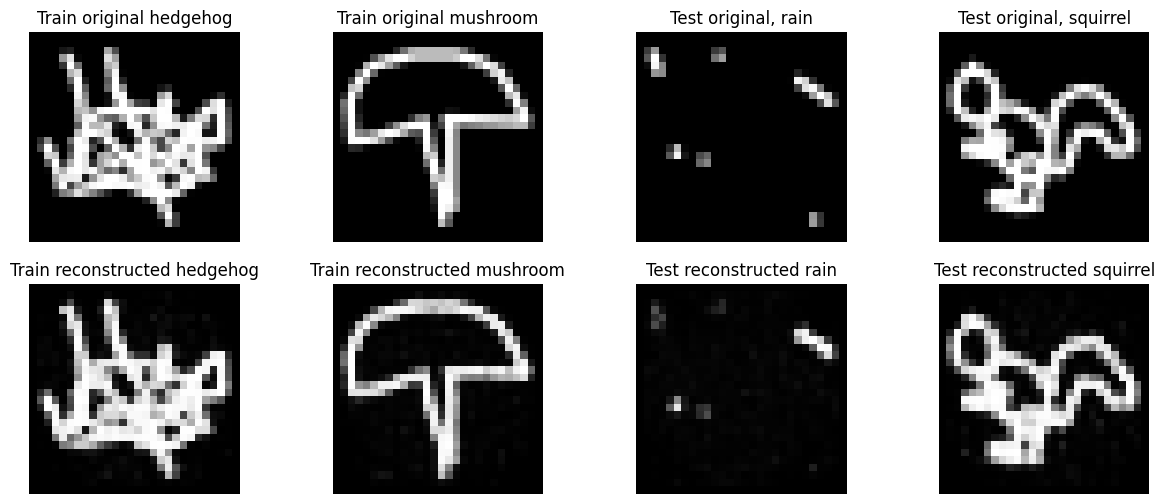

In [20]:
# Call the function
show_images(train_images, train_labels, autoencoder_model)

In [21]:
# Show image with the lowest psnr then ssim in the test set
def return_lowest_image_index_psnr_ssim(test_images, autoencoder_model):
    lowest_psnr = 100
    lowest_ssim = 100
    lowest_psnr_index = 0
    lowest_ssim_index = 0

    for i in range(len(test_images)):
        encoded, decoded = autoencoder_model(test_torch_images[i].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        image_matrix = test_images[i] / 255.0
        decoded_matrix = decoded.cpu().detach().numpy()[0]

        psnr_value = psnr(image_matrix, decoded_matrix)
        ssim_value = ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())
        
        if psnr_value < lowest_psnr:
            lowest_psnr = psnr_value
            lowest_psnr_index = i

        if ssim_value < lowest_ssim:
            lowest_ssim = ssim_value
            lowest_ssim_index = i

    return [lowest_psnr_index, lowest_psnr], [lowest_ssim_index, lowest_ssim]

lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(test_images, autoencoder_model)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

/tmp/ipykernel_6569/214677014.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(image_matrix, decoded_matrix)


Lowest PSNR index: 728|16.679545877351284, Lowest SSIM index: 669|0.4892973684763451


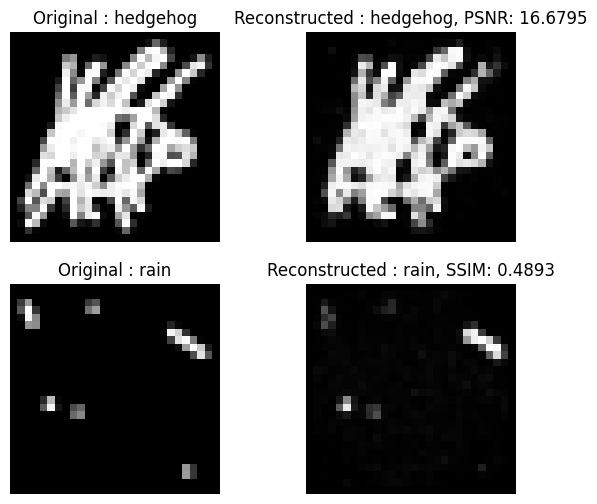

In [22]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
def show_lowest_psnr_ssim_image(test_images, autoencoder_model, lowest_psnr, lowest_ssim):
    lowest_psnr_index, psnr  = lowest_psnr
    psnr_image_label = test_labels[lowest_psnr_index]

    lowest_ssim_index, ssim  = lowest_ssim
    ssim_image_label = test_labels[lowest_ssim_index]

    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    # PSNR image
    axes[0, 0].imshow(test_images[lowest_psnr_index], cmap='gray')
    axes[0, 0].set_title("Original : " + psnr_image_label)
    axes[0, 0].axis('off')

    encoded, decoded = autoencoder_model(test_torch_images[lowest_psnr_index].view(-1, WIDTH * HEIGHT))
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[0, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[0, 1].set_title(f"Reconstructed : {psnr_image_label}, PSNR: {psnr:.4f}")
    axes[0, 1].axis('off')

    # SSIM image
    axes[1, 0].imshow(test_images[lowest_ssim_index], cmap='gray')
    axes[1, 0].set_title("Original : " + ssim_image_label)
    axes[1, 0].axis('off')

    encoded, decoded = autoencoder_model(test_torch_images[lowest_ssim_index].view(-1, WIDTH * HEIGHT))
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[1, 1].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[1, 1].set_title(f"Reconstructed : {ssim_image_label}, SSIM: {ssim:.4f}")
    axes[1, 1].axis('off')

    plt.show()


# Call the function
show_lowest_psnr_ssim_image(test_images, autoencoder_model, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [25]:
#layers = [WIDTH * HEIGHT, WIDTH * HEIGHT // ]
autocoder_2 = Autoencoder().to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / layers[-1]}')

IndexError: list index out of range

In [26]:
# Call the function
num_epochs = 50
batch_size = 32

train_loss_values, test_loss_values, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autocoder_2, train_torch_images, test_torch_images, criterion, optimizer, num_epochs, batch_size)

NameError: name 'autocoder_2' is not defined

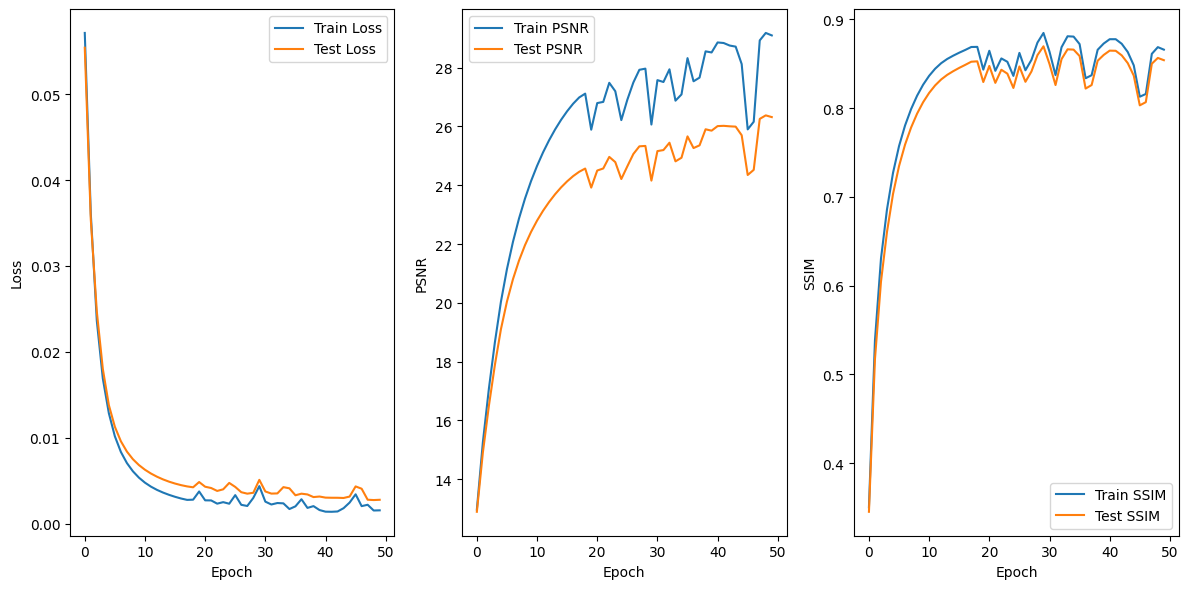

In [ ]:
plot_psnr_ssim(train_loss_values, test_loss_values, train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

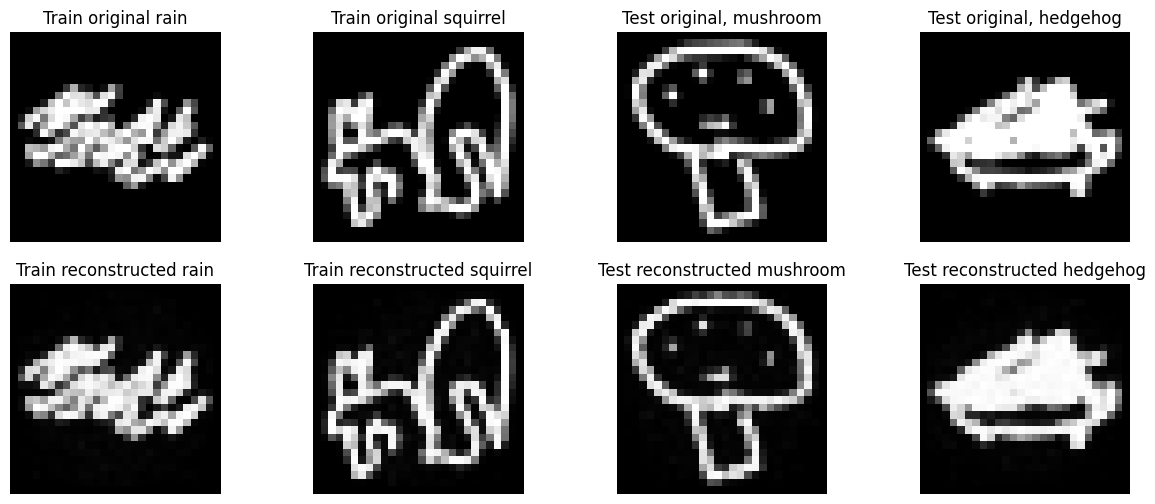

In [ ]:
show_images(train_images, train_labels, autocoder_2)

/tmp/ipykernel_14498/214677014.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(image_matrix, decoded_matrix)


Lowest PSNR index: 72|18.032498353554544, Lowest SSIM index: 616|0.42506029117960403


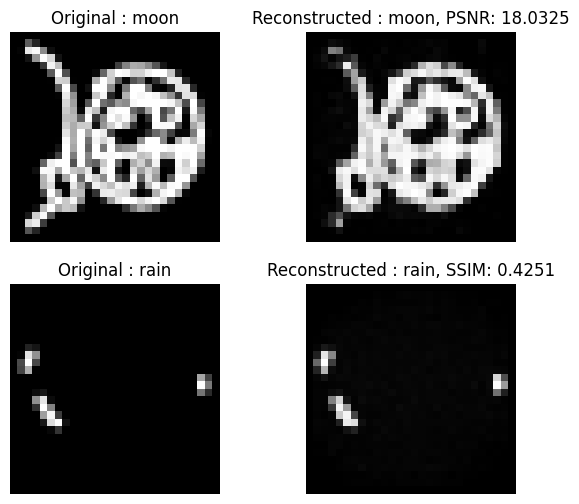

In [ ]:
lowest_psnr, lowest_ssim = return_lowest_image_index_psnr_ssim(test_images, autocoder_2)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

show_lowest_psnr_ssim_image(test_images, autocoder_2, lowest_psnr, lowest_ssim)

## Try with resnet18 architecture

In [ ]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mabazin/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define a function to train the model
def train_pretained_model():
    

SyntaxError: incomplete input (1788380066.py, line 3)